# SKOLTECH, Experimental Data Processing

## Evgenii Safronov, Mikhail Kurenkov, Taras Melnik

In [1]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from numpy.linalg import inv
import matplotlib as mplb
from matplotlib.font_manager import FontProperties
%matplotlib inline
from numpy.random import normal
from mpl_toolkits.mplot3d import Axes3D
mplb.rc('xtick', labelsize=5) 
mplb.rc('ytick', labelsize=5) 

In [19]:
def generate_trajectory(sigma_w_2, sigma_n_2, M, X_0):
    sigma_w = sigma_w_2 ** 0.5
    sigma_n = sigma_n_2 ** 0.5
    w = np.random.normal(0, sigma_w, M)
    n = np.random.normal(0, sigma_n, M)

    x = w.dot(np.tril(np.ones((M, M)))) + X_0 * np.ones(M)
    z = x + n
    return x, z

def generate_acc_trajectory(sigma_a_2, sigma_n_2, N, x_0, v_0, t):
    a = np.random.normal(0, sigma_a_2 ** 0.5, N)
    v = np.ones(N) * v_0 + a.dot(np.triu(np.ones((N, N)), 1)) * t
    x = np.ones(N) * x_0 + (v_1 * t + a * t * t / 2).dot(np.triu(np.ones((N, N)), 1))
    z = x + np.random.normal(0, sigma_n_2 ** 0.5, N)
    return x, z

def calculate_exp_w_n(z):
    v = z - np.roll(z,1)
    p = z - np.roll(z,2)
    E_v = np.average((v ** 2)[1:])
    E_p = np.average((p ** 2)[2:])
    return E_p - E_v, E_v - E_p / 2

def alpha_opt(sigma_w_2, sigma_n_2):
    chi = sigma_w_2 / sigma_n_2
    return (-chi + (chi**2 + 4 * chi) ** 0.5) / 2

def M_opt(alpha):
    return int(round((2 - alpha) / alpha))

def running_mean(z, M, mask=None):
    if mask is None:
        mask = np.ones(M) / M
    m = int(M/2)
    z_ext = np.zeros(len(z) + 2 * m)
    z_ext[:m] = np.flip(z[:m], 0)
    z_ext[-m:] = np.flip(z[-m:], 0)
    z_ext[m:-m] = z
    return np.convolve(z_ext, mask, mode="same")[m:-m]

def exp_mean(z, alpha):
    exp_mean_z = z.copy()
    for i in range(1, len(z)):
        exp_mean_z[i] = exp_mean_z[i - 1] + alpha * (z[i] - exp_mean_z[i - 1])
    return exp_mean_z

def backward_exp_mean(x_f, alpha):
    x_b = x_f.copy()
    for i in range(len(x_b)-2,-1,-1):
        x_b[i] = x_b[i+1] + alpha*(x_f[i] - x_b[i+1])
    return x_b

# Part 1

In [76]:
#T - transport matrix
#G - input
#z - measurements
#H - obs
#sigma_n - noise
#sigma_a - acc noise
#R = sigma_n**2 
#P_0 
def kalman(X_0, P_0, z, T, H, R, Q):
    X = np.zeros((len(z),*(X_0.shape)))
    P = np.zeros((len(z),*(P_0.shape)))
    K = np.zeros_like(X) # ??? if z[i] not number
    for i,z_i in enumerate(z):
        #Prediction
        X[i] = T.dot(X[i-1] if i > 0 else X_0)
        P[i] = T.dot((P[i-1] if i > 0 else P_0).dot(T.transpose())) + Q
        #Filtration
        tmp1 = inv(H.dot(P[i].dot(H.transpose())) + R)
        tmp2 = H.transpose().dot(tmp1)
        K[i] = P[i].dot(tmp2)
        print('tmp1 ')
        print(tmp1)
        print('tmp2 ')
        print(tmp2)
        print('K')
        print(K[i])
        X[i] = X[i] + K[i]*(z[i] - H.dot(X[i]))
        P[i] = (np.identity(len(H)) - K[i].dot(H)).dot(P[i])
    return X,K
        

### Parameters

In [84]:
N = 300
sigma_a = 0.2
sigma_n = 20
x_1 = 5
v_1 = 1
t = 1
X_0 = np.array([[2],[0]])
P_0 = np.matrix([[10000, 0], [0,10000]])
G = np.array([[t**2/2], [t]])
H = np.array([[1, 0]])
Q = G.dot(G.transpose())*sigma_a**2
R = np.array([[sigma_n**2]])
T = np.matrix([[1, t],[0,1]])

In [85]:
x, z = generate_acc_trajectory(sigma_a**2, sigma_n**2, N, x_1, v_1, t)

In [86]:
X, K = kalman(X_0, P_0, z, T, H, R, Q)

tmp1 
[[  4.99001971e-06]]
tmp2 
[[  4.99001971e-06]
 [  0.00000000e+00]]
K
[[ 0.99800399]
 [ 0.49900207]]
tmp1 
[[  1.81389994e-06]]
tmp2 
[[  1.81389994e-06]
 [  0.00000000e+00]]
K
[[ 0.99927444]
 [ 0.63540819]]
tmp1 
[[  7.72863104e-07]]
tmp2 
[[  7.72863104e-07]
 [  0.00000000e+00]]
K
[[ 0.99969085]
 [ 0.61250138]]
tmp1 
[[  3.67425625e-07]]
tmp2 
[[  3.67425625e-07]
 [  0.00000000e+00]]
K
[[ 0.99985303]
 [ 0.61979254]]
tmp1 
[[  1.83933664e-07]]
tmp2 
[[  1.83933664e-07]
 [  0.00000000e+00]]
K
[[ 0.99992643]
 [ 0.61725954]]
tmp1 
[[  9.56439867e-08]]
tmp2 
[[  9.56439867e-08]
 [  0.00000000e+00]]
K
[[ 0.99996174]
 [ 0.61827041]]
tmp1 
[[  5.09935078e-08]]
tmp2 
[[  5.09935078e-08]
 [  0.00000000e+00]]
K
[[ 0.9999796 ]
 [ 0.61791316]]
tmp1 
[[  2.77156287e-08]]
tmp2 
[[  2.77156287e-08]
 [  0.00000000e+00]]
K
[[ 0.99998891]
 [ 0.61806365]]
tmp1 
[[  1.52849372e-08]]
tmp2 
[[  1.52849372e-08]
 [  0.00000000e+00]]
K
[[ 0.99999389]
 [ 0.61801365]]
tmp1 
[[  8.52863414e-09]]
tmp2 
[[  

K
[[ 1.        ]
 [ 0.61803399]]
tmp1 
[[  6.89330996e-24]]
tmp2 
[[  6.89330996e-24]
 [  0.00000000e+00]]
K
[[ 1.        ]
 [ 0.61803399]]
tmp1 
[[  4.20656927e-24]]
tmp2 
[[  4.20656927e-24]
 [  0.00000000e+00]]
K
[[ 1.        ]
 [ 0.61803399]]
tmp1 
[[  2.56742264e-24]]
tmp2 
[[  2.56742264e-24]
 [  0.00000000e+00]]
K
[[ 1.        ]
 [ 0.61803399]]
tmp1 
[[  1.56723479e-24]]
tmp2 
[[  1.56723479e-24]
 [  0.00000000e+00]]
K
[[ 1.        ]
 [ 0.61803399]]
tmp1 
[[  9.56833752e-25]]
tmp2 
[[  9.56833752e-25]
 [  0.00000000e+00]]
K
[[ 1.        ]
 [ 0.61803399]]
tmp1 
[[  5.84255822e-25]]
tmp2 
[[  5.84255822e-25]
 [  0.00000000e+00]]
K
[[ 1.        ]
 [ 0.61803399]]
tmp1 
[[  3.56806058e-25]]
tmp2 
[[  3.56806058e-25]
 [  0.00000000e+00]]
K
[[ 1.        ]
 [ 0.61803399]]
tmp1 
[[  2.17932761e-25]]
tmp2 
[[  2.17932761e-25]
 [  0.00000000e+00]]
K
[[ 1.        ]
 [ 0.61803399]]
tmp1 
[[  1.33128956e-25]]
tmp2 
[[  1.33128956e-25]
 [  0.00000000e+00]]
K
[[ 1.        ]
 [ 0.61803399]]
tmp1

tmp2 
[[  5.69147973e-42]
 [  0.00000000e+00]]
K
[[ 1.        ]
 [ 0.61803399]]
tmp1 
[[  3.49611744e-42]]
tmp2 
[[  3.49611744e-42]
 [  0.00000000e+00]]
K
[[ 1.        ]
 [ 0.61803399]]
tmp1 
[[  2.14764712e-42]]
tmp2 
[[  2.14764712e-42]
 [  0.00000000e+00]]
K
[[ 1.        ]
 [ 0.61803399]]
tmp1 
[[  1.31933696e-42]]
tmp2 
[[  1.31933696e-42]
 [  0.00000000e+00]]
K
[[ 1.        ]
 [ 0.61803399]]
tmp1 
[[  8.10520945e-43]]
tmp2 
[[  8.10520945e-43]
 [  0.00000000e+00]]
K
[[ 1.        ]
 [ 0.61803399]]
tmp1 
[[  4.97952908e-43]]
tmp2 
[[  4.97952908e-43]
 [  0.00000000e+00]]
K
[[ 1.        ]
 [ 0.61803399]]
tmp1 
[[  3.05933925e-43]]
tmp2 
[[  3.05933925e-43]
 [  0.00000000e+00]]
K
[[ 1.        ]
 [ 0.61803399]]
tmp1 
[[  1.87967238e-43]]
tmp2 
[[  1.87967238e-43]
 [  0.00000000e+00]]
K
[[ 1.        ]
 [ 0.61803399]]
tmp1 
[[  1.15491934e-43]]
tmp2 
[[  1.15491934e-43]
 [  0.00000000e+00]]
K
[[ 1.        ]
 [ 0.61803399]]
tmp1 
[[  7.09636514e-44]]
tmp2 
[[  7.09636514e-44]
 [  0.00000

[[  7.21919844e-67]
 [  0.00000000e+00]]
K
[[ 1.        ]
 [ 0.61803399]]
tmp1 
[[  4.44590459e-67]]
tmp2 
[[  4.44590459e-67]
 [  0.00000000e+00]]
K
[[ 1.        ]
 [ 0.61803399]]
tmp1 
[[  2.73802083e-67]]
tmp2 
[[  2.73802083e-67]
 [  0.00000000e+00]]
K
[[ 1.        ]
 [ 0.61803399]]
tmp1 
[[  1.68623760e-67]]
tmp2 
[[  1.68623760e-67]
 [  0.00000000e+00]]
K
[[ 1.        ]
 [ 0.61803399]]
tmp1 
[[  1.03849919e-67]]
tmp2 
[[  1.03849919e-67]
 [  0.00000000e+00]]
K
[[ 1.        ]
 [ 0.61803399]]
tmp1 
[[  6.39585919e-68]]
tmp2 
[[  6.39585919e-68]
 [  0.00000000e+00]]
K
[[ 1.        ]
 [ 0.61803399]]
tmp1 
[[  3.93909925e-68]]
tmp2 
[[  3.93909925e-68]
 [  0.00000000e+00]]
K
[[ 1.        ]
 [ 0.61803399]]
tmp1 
[[  2.42605261e-68]]
tmp2 
[[  2.42605261e-68]
 [  0.00000000e+00]]
K
[[ 1.        ]
 [ 0.61803399]]
tmp1 
[[  1.49420000e-68]]
tmp2 
[[  1.49420000e-68]
 [  0.00000000e+00]]
K
[[ 1.        ]
 [ 0.61803399]]
tmp1 
[[  9.20285198e-69]]
tmp2 
[[  9.20285198e-69]
 [  0.00000000e+0

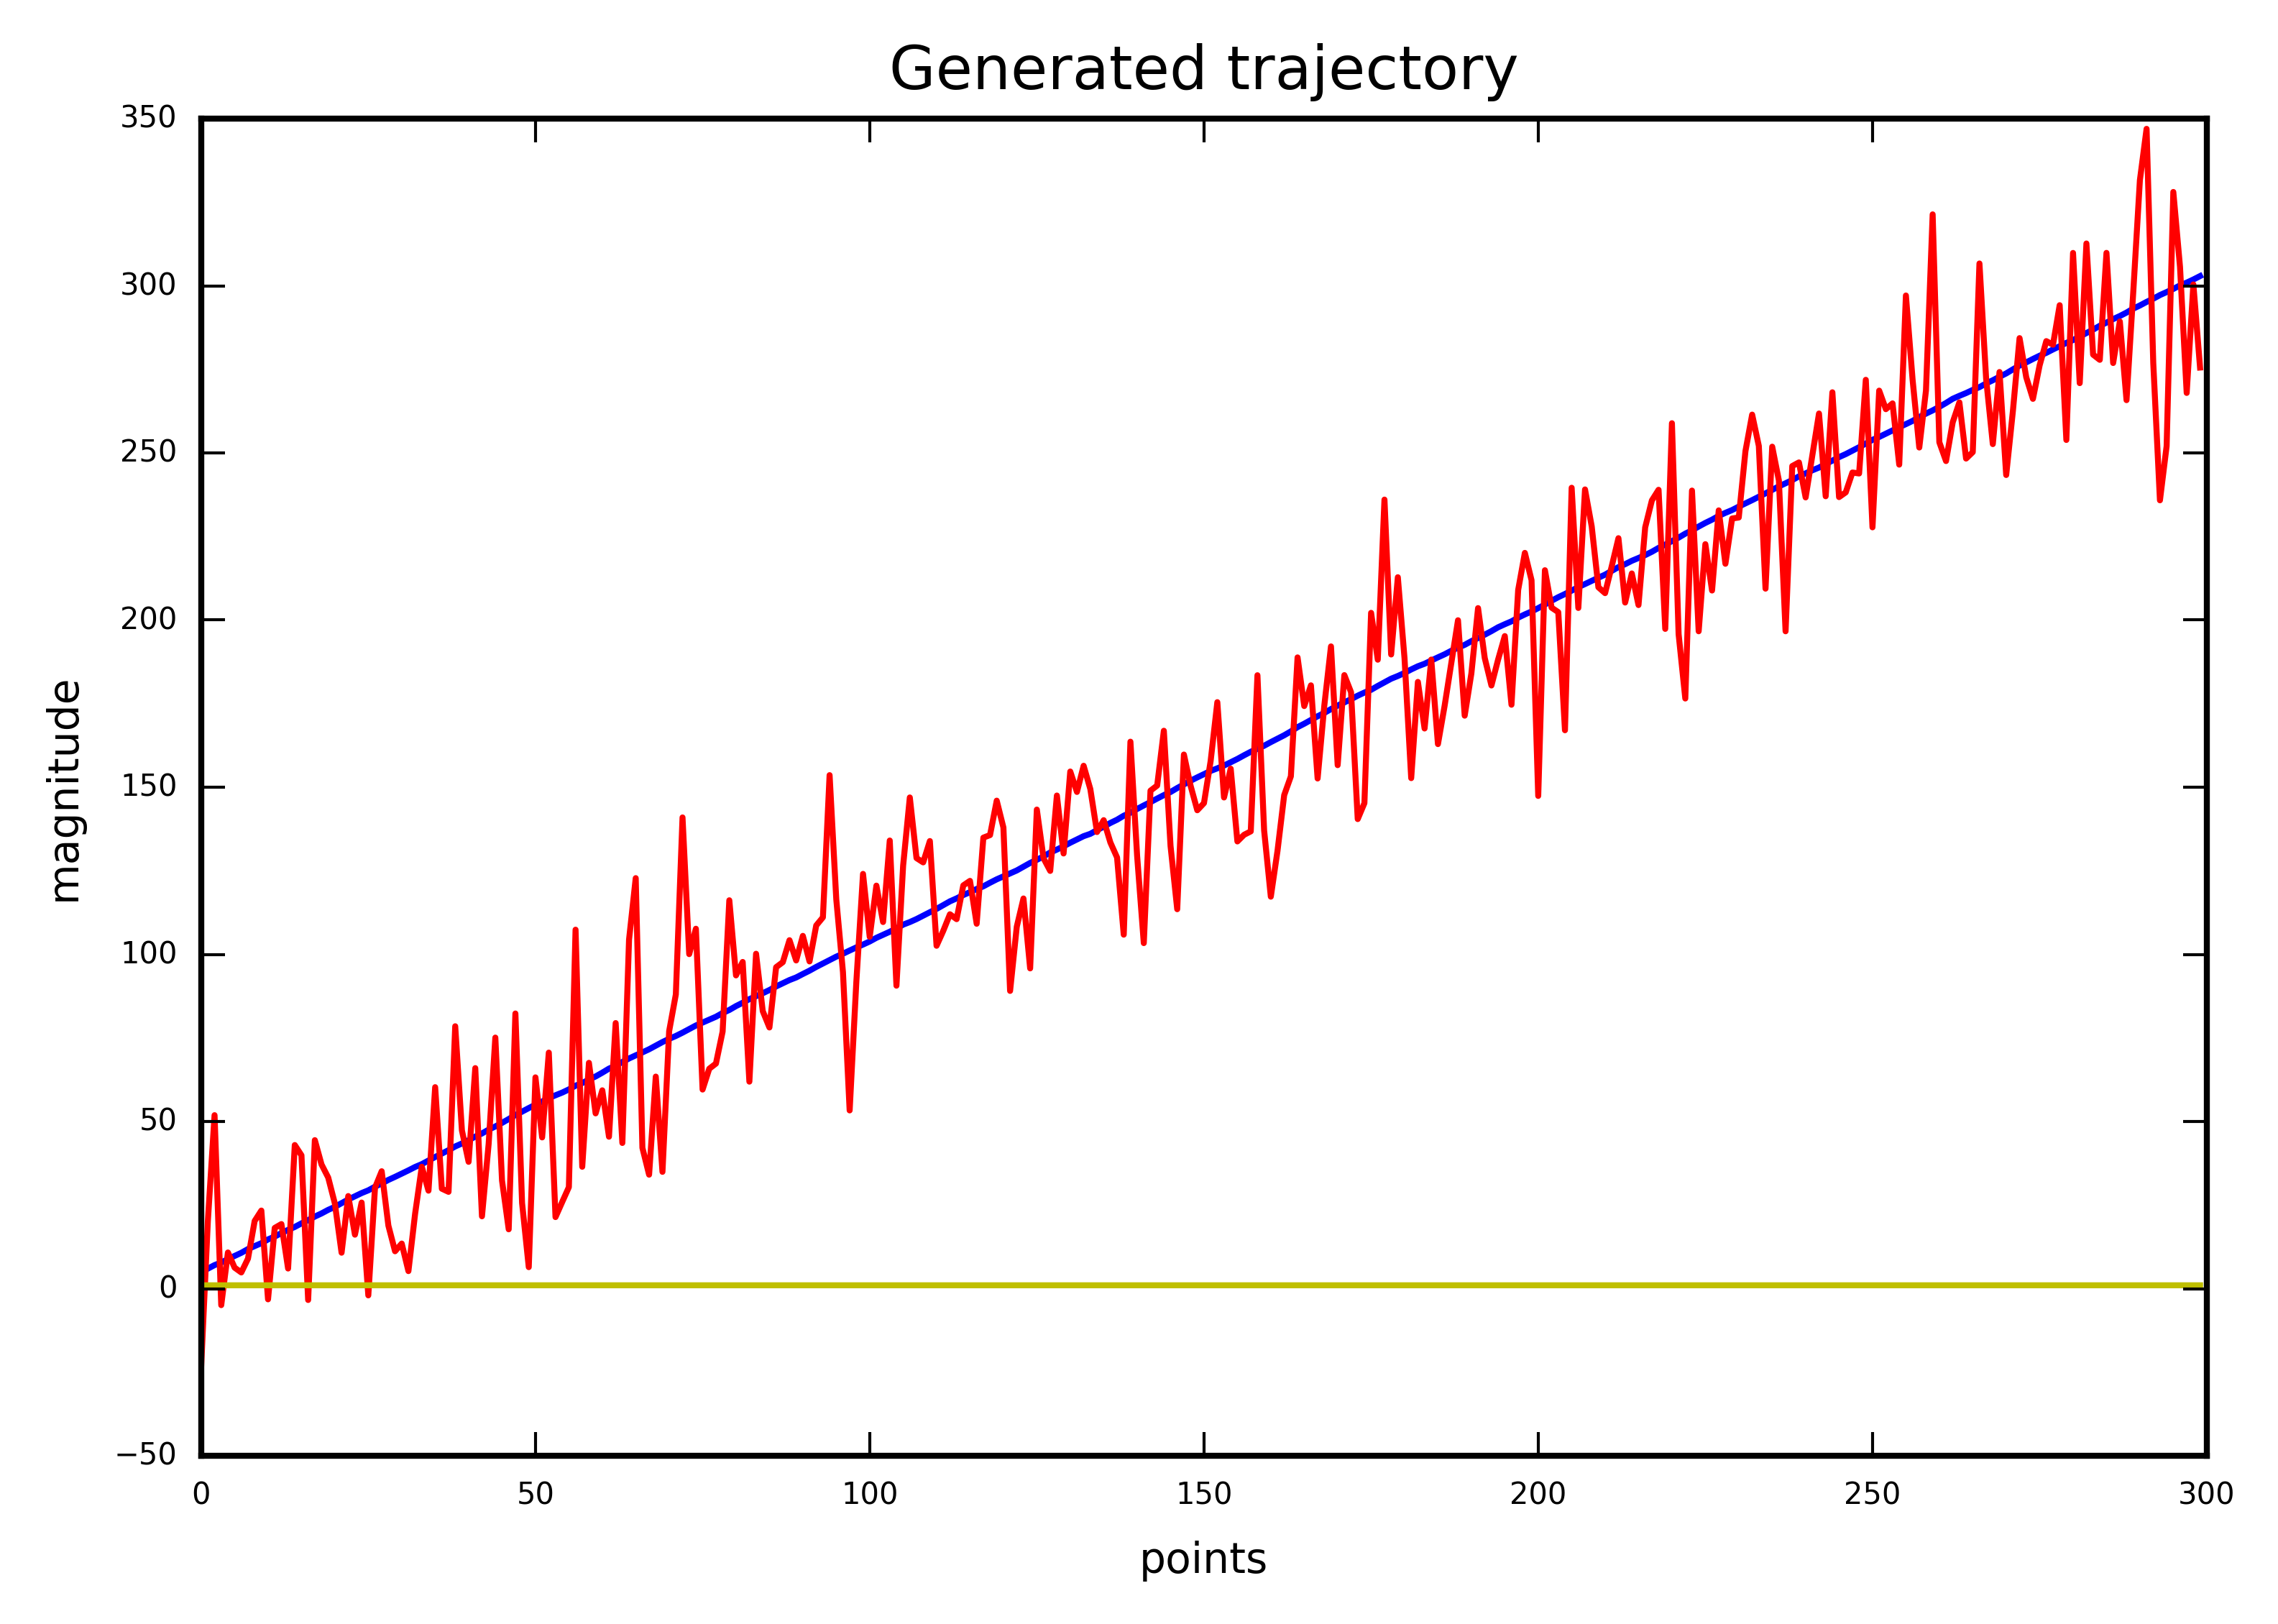

In [87]:
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi = 600)
ax.set_title('Generated trajectory', fontsize = 10)
ax.plot(range(N),z,'g', label = 'z', linewidth = 0.5 )
ax.plot(range(N),x,'b', label = 'x', linewidth = 1 )
ax.plot(range(N),X[:,0].transpose()[0],'r', label = 'X', linewidth = 1 )
ax.plot(range(N),K[:,0].transpose()[0],'y', label = 'K', linewidth = 1 )
#ax.set_xlim([0,20])
ax.set_xlabel('points', fontsize = 7)
ax.set_ylabel('magnitude', fontsize = 7);

In [75]:
np.sum((X[:,0].transpose()[0]-z)**2)
X[:,0].transpose()[0][0]

-1.4097689413670151

In [72]:
np.identity(2).dot(np.array([[1],[0]]))

array([[ 1.],
       [ 0.]])

In [ ]:
fun()